# Imports

In [1]:
import sys
from pathlib import Path

AVES_ROOT = Path("../..") if not "google.colab" in sys.modules else Path("aves_git")
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
# mpl.rcParams["figure.dpi"] = 150
# esto depende de las fuentes que tengas instaladas en el sistema.
# mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"

# Carga de Datos (EOD y areas verdes)

In [2]:
from aves.data import eod
#load
EOD_PATH = AVES_ROOT / "data" / "external" / "EOD_STGO"

hogares = eod.read_homes(EOD_PATH)
personas = eod.read_people(EOD_PATH)
viajes = eod.read_trips(EOD_PATH)

# print columns
print("hogares: \n", hogares.columns)
print("personas: \n", personas.columns)
print("viajes: \n", viajes.columns)

hogares: 
 Index(['Hogar', 'Sector', 'Zona', 'Comuna', 'DirCoordX', 'DirCoordY', 'Fecha',
       'DiaAsig', 'TipoDia', 'Temporada', 'NumPer', 'NumVeh', 'NumBicAdulto',
       'NumBicNino', 'Propiedad', 'MontoDiv', 'ImputadoDiv', 'MontoArr',
       'ImputadoArr', 'IngresoHogar', 'FactorHogar'],
      dtype='object')
personas: 
 Index(['Hogar', 'Persona', 'AnoNac', 'Sexo', 'Relacion', 'Viajes',
       'LicenciaConducir', 'PaseEscolar', 'AdultoMayor', 'Estudios', 'Curso',
       'Actividad', 'Ocupacion', 'ActividadEmpresa', 'JornadaTrabajo',
       'DondeEstudia', 'DirActividadCoordX', 'DirActividadCoordY',
       'DirEstudiosCoordX', 'DirEstudiosCoordY', 'NoViaja', 'TarjetaBip',
       'Tarjeta2Bip', 'MedioViajeRestricion', 'ConoceTransantiago',
       'NoUsaTransantiago', 'Discapacidad', 'TieneIngresos', 'Ingreso',
       'TramoIngreso', 'IngresoFinal', 'TramoIngresoFinal', 'IngresoImputado',
       'Factor_LaboralNormal', 'Factor_SabadoNormal', 'Factor_DomingoNormal',
       'Factor_La

In [3]:
# Load
areas_verdes = (
    gpd.read_file(AVES_ROOT / "data" / "project" / "Superficie_de_Areas_Verdes_Santiago.geojson")
)
print("areas_verdes: \n", areas_verdes.columns)

areas_verdes: 
 Index(['FID', 'comuna', 'estado', 'area_m2', 'area_ha', 'estado_2', 'id',
       'shapearea', 'layer', 'shape_leng', 'shape_area', 'clase',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')


## Arreglos a los datos

In [4]:
# corregimos nombres de columna
areas_verdes = areas_verdes.rename(columns={"comuna": "Comuna"})
# corregimos comunas con distinto nombre
areas_verdes["Comuna"] = areas_verdes["Comuna"].replace(["ESTACION CENTRA", "NUNOA", "PAC", "PENALOLEN"], ["ESTACION CENTRAL", "ÑUÑOA", "PEDRO AGUIRRE CERDA", "PEÑALOLEN"])
# cambiamos areas_verdes con clase "AV PARQUE" a "PARQUE"
areas_verdes["clase"] = areas_verdes["clase"].replace(["AV PARQUE"], ["PARQUE"])
# cambiamos areas_verdes con estado "DESAFECTADA e" a "DESAFECTADA"
areas_verdes["estado"] = areas_verdes["estado"].replace(["DESAFECTADA VERDE e"], ["DESAFECTADA VERDE"])

print("Comunas no presentes en areas_verdes: \n", set(hogares["Comuna"]) - set(areas_verdes["Comuna"]))

# filtramos hogares por comunas presentes en areas_verdes
hogares = hogares[hogares["Comuna"].isin(areas_verdes["Comuna"].unique())]

Comunas no presentes en areas_verdes: 
 {'ISLA DE MAIPO', 'EL MONTE', 'PIRQUE', 'PEÑAFLOR', 'BUIN', 'MELIPILLA', 'LAMPA', 'TALAGANTE', 'COLINA', 'CALERA DE TANGO', 'PADRE HURTADO'}


# Visualizaciones

## Datos graficados por clase

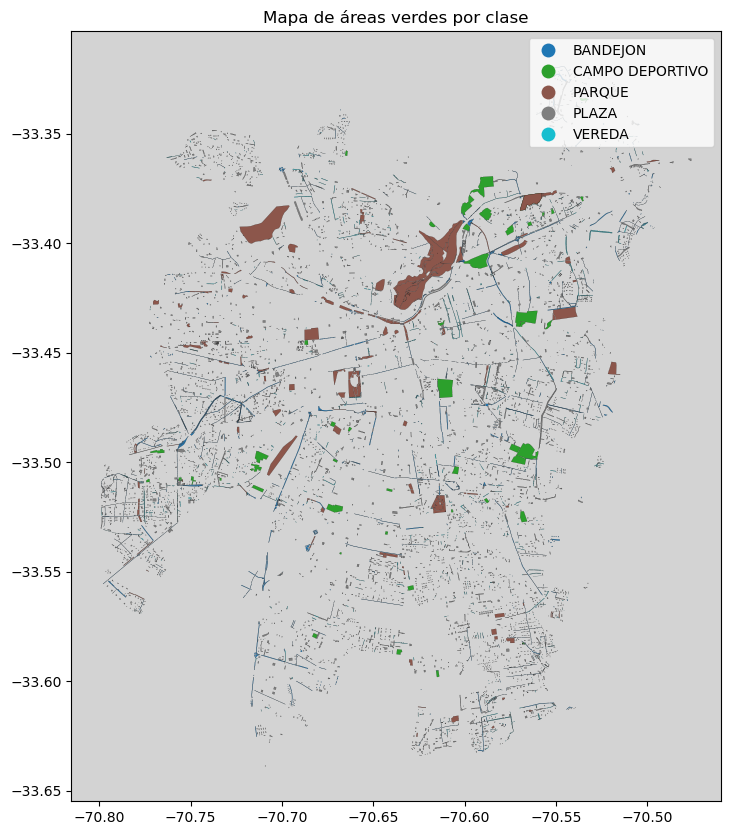

In [5]:
ax = areas_verdes.plot(figsize=(10, 10), column='clase', legend=True, edgecolor="black", linewidth=0.1)
ax.set_title("Mapa de áreas verdes por clase")
ax.set_facecolor("lightgray")

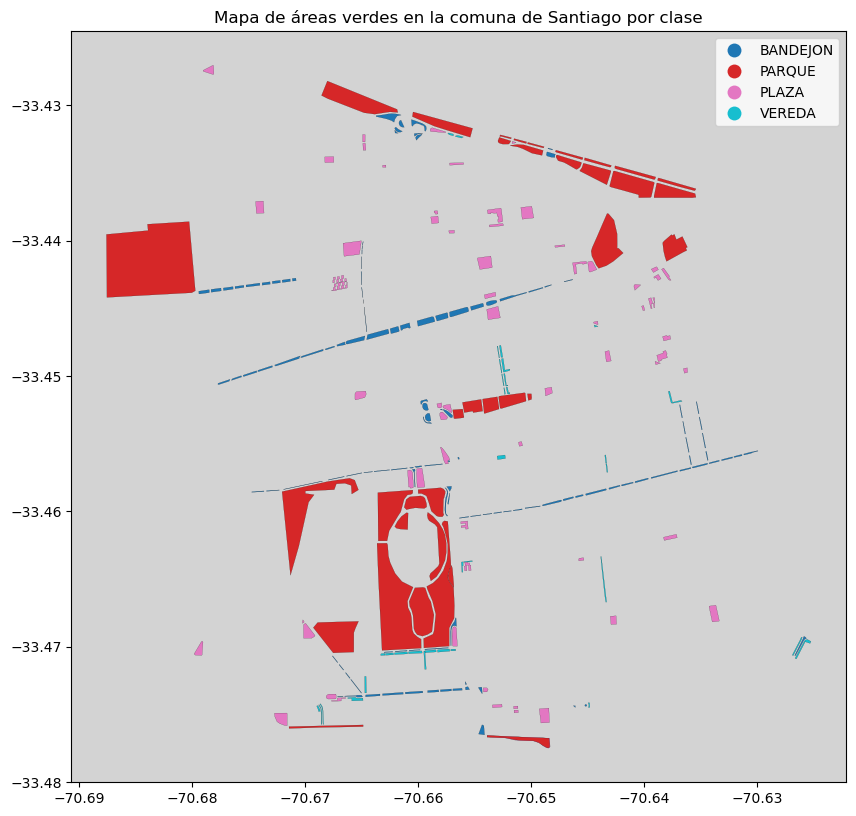

In [6]:
areas_verdes_santiago = areas_verdes[areas_verdes['Comuna'] == 'SANTIAGO']
ax = areas_verdes_santiago.plot(figsize=(10, 10), column='clase', legend=True, edgecolor="black", linewidth=0.1)
ax.set_title("Mapa de áreas verdes en la comuna de Santiago por clase")
ax.set_facecolor("lightgray")

### ¿Cual es la superficie total de los tipos de areas verdes?

,area_m2,area_ha,area_km2
clase,,,
VEREDA,1.611821e+06,161.182139,1.611821
PLAZA,1.146003e+07,1146.003313,11.460033
PARQUE,1.496135e+07,1496.134607,14.961346
CAMPO DEPORTIVO,6.257280e+06,625.728011,6.257280
BANDEJON,3.960929e+06,396.092897,3.960929


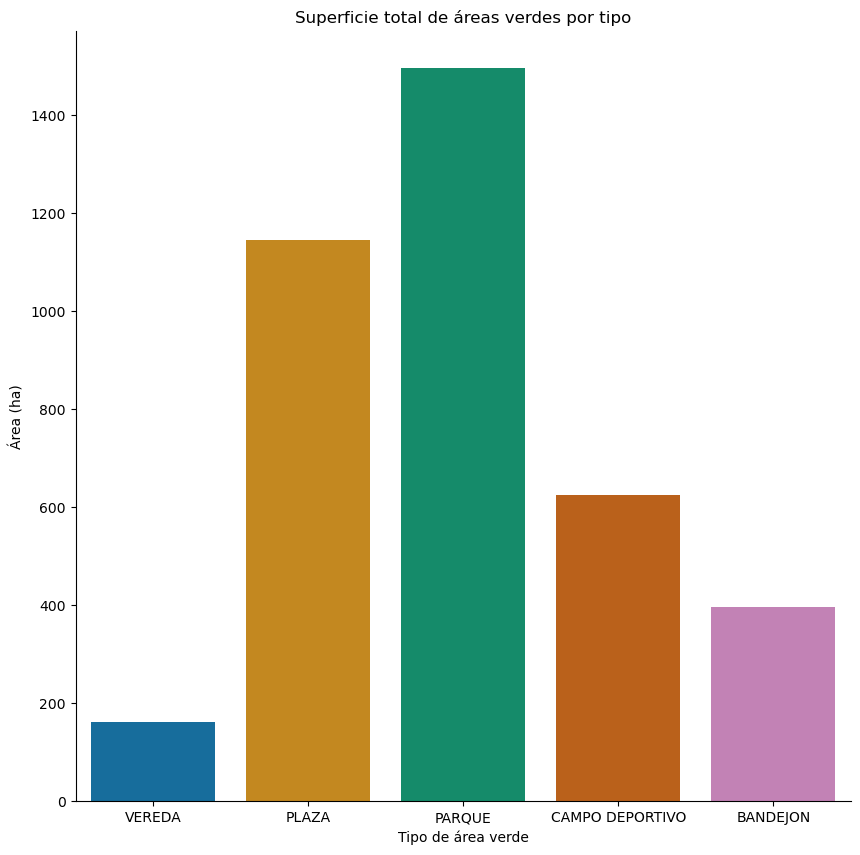

In [20]:
# superficie total por tipo de área verde
superficie_total_tipo = areas_verdes.groupby("clase").agg({"area_m2": "sum", "area_ha": "sum"}).sort_values("clase", ascending=False)
superficie_total_tipo["area_km2"] = superficie_total_tipo["area_m2"] / 1e6

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    data=superficie_total_tipo,
    x=superficie_total_tipo.index,
    y="area_ha",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Tipo de área verde")
ax.set_ylabel("Área (ha)")
ax.set_title("Superficie total de áreas verdes por tipo")
sns.despine()

superficie_total_tipo


### ¿Y su promedio de superficie?

,area_m2,area_ha,area_km2
clase,,,
VEREDA,680.667774,0.068067,0.000681
PLAZA,1773.449870,0.177345,0.001773
PARQUE,69912.832467,6.991283,0.069913
CAMPO DEPORTIVO,127699.596939,12.769959,0.127700
BANDEJON,1578.688413,0.157869,0.001579


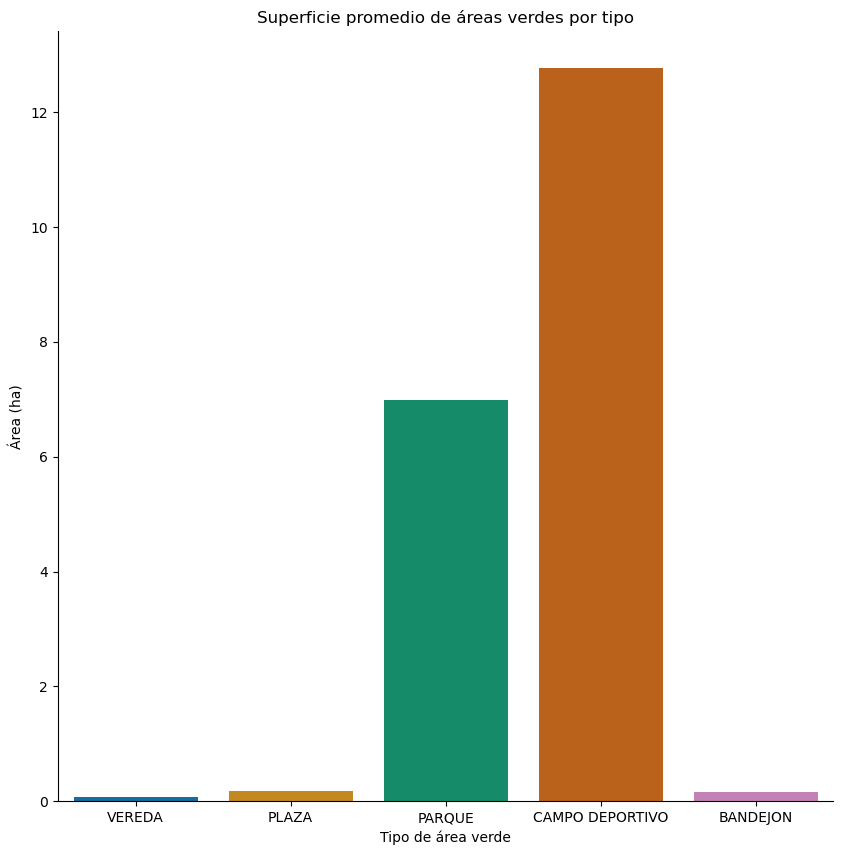

In [17]:
# promedio de superficie por tipo
superficie_promedio_tipo = areas_verdes.groupby("clase").agg({"area_m2": "mean", "area_ha": "mean"}).sort_values("clase", ascending=False)
superficie_promedio_tipo["area_km2"] = superficie_promedio_tipo["area_m2"] / 1e6

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    data=superficie_promedio_tipo,
    x=superficie_promedio_tipo.index,
    y="area_ha",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Tipo de área verde")
ax.set_ylabel("Área (ha)")
ax.set_title("Superficie promedio de áreas verdes por tipo")
sns.despine()

superficie_promedio_tipo

## Superficie y cantidad de areas verdes por comuna

,Comuna,clase,area_m2,n_areas,area_ha
0,CERRILLOS,BANDEJON,51218.342,39,5.121834
1,CERRILLOS,CAMPO DEPORTIVO,437046.097,5,43.704610
2,CERRILLOS,PARQUE,566657.890,2,56.665789
3,CERRILLOS,PLAZA,257345.039,87,25.734504
4,CERRILLOS,VEREDA,36666.459,58,3.666646
...,...,...,...,...,...
145,ÑUÑOA,BANDEJON,146049.146,126,14.604915
146,ÑUÑOA,CAMPO DEPORTIVO,636003.733,1,63.600373
147,ÑUÑOA,PARQUE,50444.613,5,5.044461
148,ÑUÑOA,PLAZA,536582.664,190,53.658266


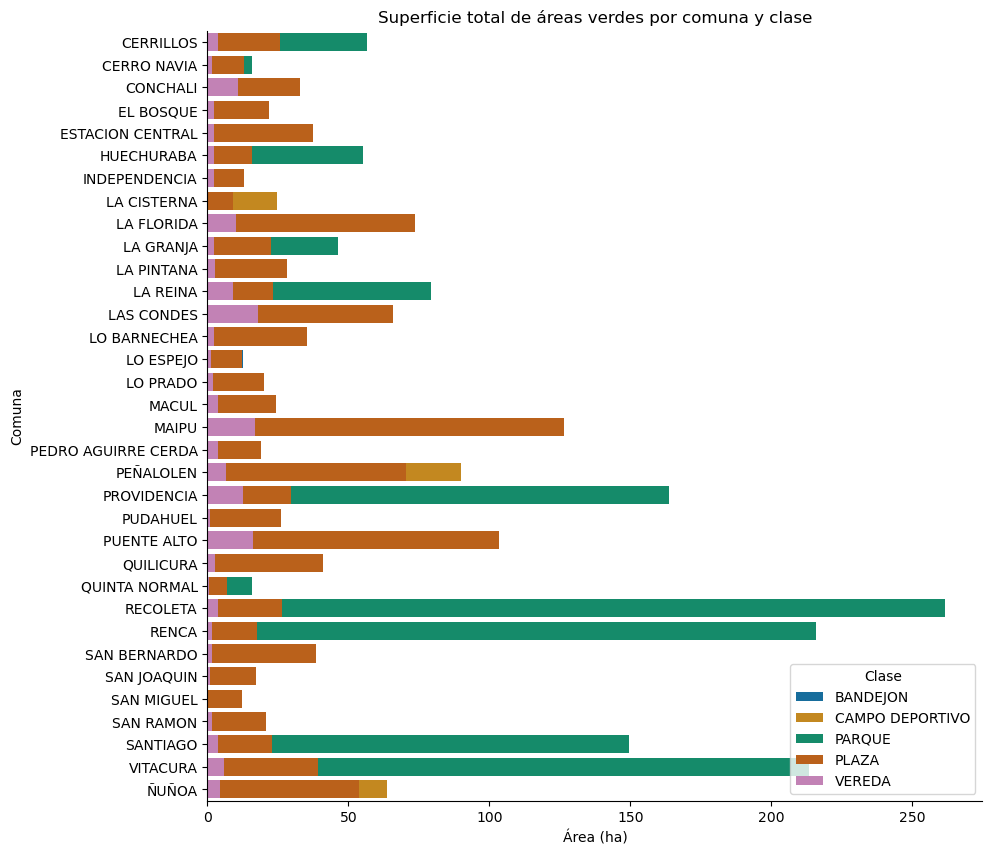

In [21]:
area_comuna_clase = areas_verdes.groupby(["Comuna", "clase"]).agg({"area_m2": "sum", "Comuna": "count"}).rename(columns={"Comuna": "n_areas"}).reset_index()
area_comuna_clase["area_ha"] = area_comuna_clase["area_m2"] / 10000

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    data=area_comuna_clase,
    x="area_ha",
    y="Comuna",
    hue="clase",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Área (ha)")
ax.set_ylabel("Comuna")
ax.set_title("Superficie total de áreas verdes por comuna y clase")
ax.legend(title="Clase", loc="lower right")
sns.despine()

area_comuna_clase

,Comuna,estado,area_m2,n_areas,area_ha
0,CERRILLOS,CONSOLIDADA,145777.509,40,14.577751
1,CERRILLOS,DESAFECTADA ERIAZO,6019.921,6,0.601992
2,CERRILLOS,DESAFECTADA VERDE,1164851.979,142,116.485198
3,CERRILLOS,DETERIORADA,32284.418,3,3.228442
4,CERRO NAVIA,CONSOLIDADA,69819.898,24,6.981990
...,...,...,...,...,...
155,ÑUÑOA,CONSOLIDADA,505351.155,128,50.535115
156,ÑUÑOA,DESAFECTADA ERIAZO,2384.013,1,0.238401
157,ÑUÑOA,DESAFECTADA VERDE,901415.296,256,90.141530
158,ÑUÑOA,DETERIORADA,208.140,1,0.020814


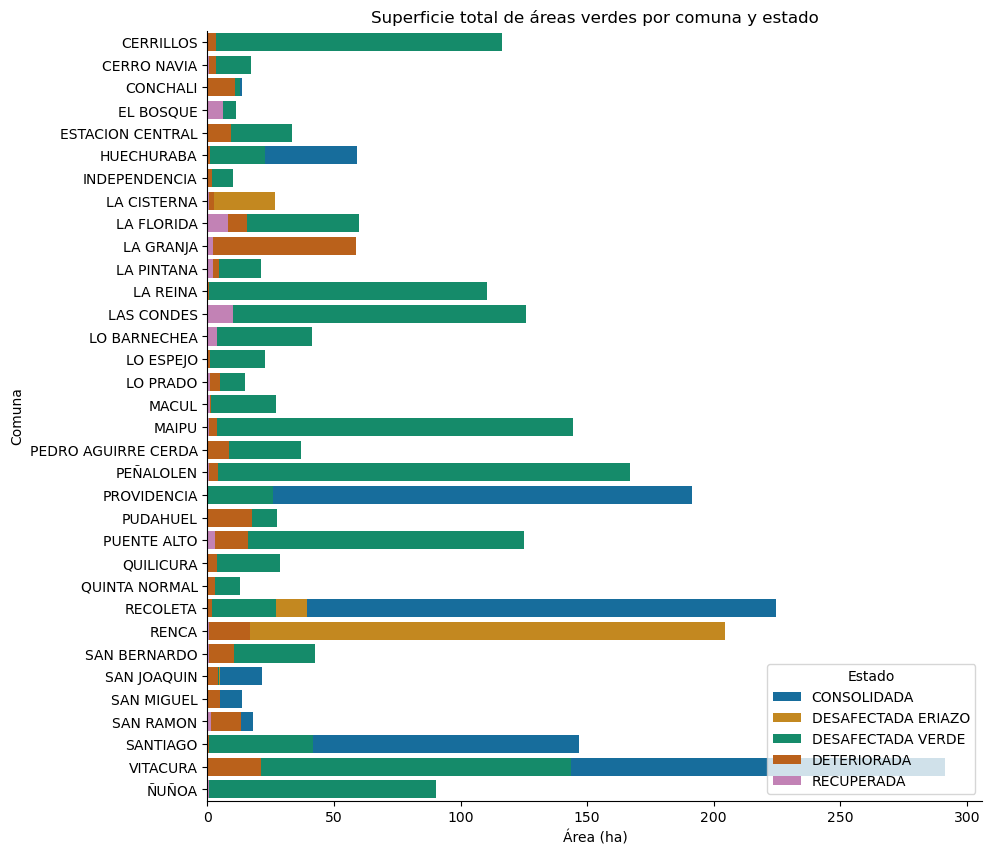

In [10]:
cantidad_comuna_estado = areas_verdes.groupby(["Comuna", "estado"]).agg({"area_m2": "sum", "Comuna": "count"}).rename(columns={"Comuna": "n_areas"}).reset_index()
cantidad_comuna_estado["area_ha"] = cantidad_comuna_estado["area_m2"] / 10000

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    data=cantidad_comuna_estado,
    x="area_ha",
    y="Comuna",
    hue="estado",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Área (ha)")
ax.set_ylabel("Comuna")
ax.set_title("Superficie total de áreas verdes por comuna y estado")
ax.legend(title="Estado", loc="lower right")
sns.despine()

cantidad_comuna_estado

### ¿Cantidad de Areas verdes se relaciona con la poblacion?
agregar grafico con areas verdes por cada 1000 habitantes

,Comuna,clase,area_m2,n_areas,area_ha,population,area_ha_por_1000_habitantes
0,CERRILLOS,BANDEJON,51218.342,39,5.121834,78575.22841,0.065184
1,CERRILLOS,CAMPO DEPORTIVO,437046.097,5,43.704610,78575.22841,0.556214
2,CERRILLOS,PARQUE,566657.890,2,56.665791,78575.22841,0.721166
3,CERRILLOS,PLAZA,257345.039,87,25.734503,78575.22841,0.327514
4,CERRILLOS,VEREDA,36666.459,58,3.666647,78575.22841,0.046664
...,...,...,...,...,...,...,...
145,ÑUÑOA,BANDEJON,146049.146,126,14.604908,211265.10313,0.069131
146,ÑUÑOA,CAMPO DEPORTIVO,636003.733,1,63.600374,211265.10313,0.301045
147,ÑUÑOA,PARQUE,50444.613,5,5.044460,211265.10313,0.023877
148,ÑUÑOA,PLAZA,536582.664,190,53.658268,211265.10313,0.253985


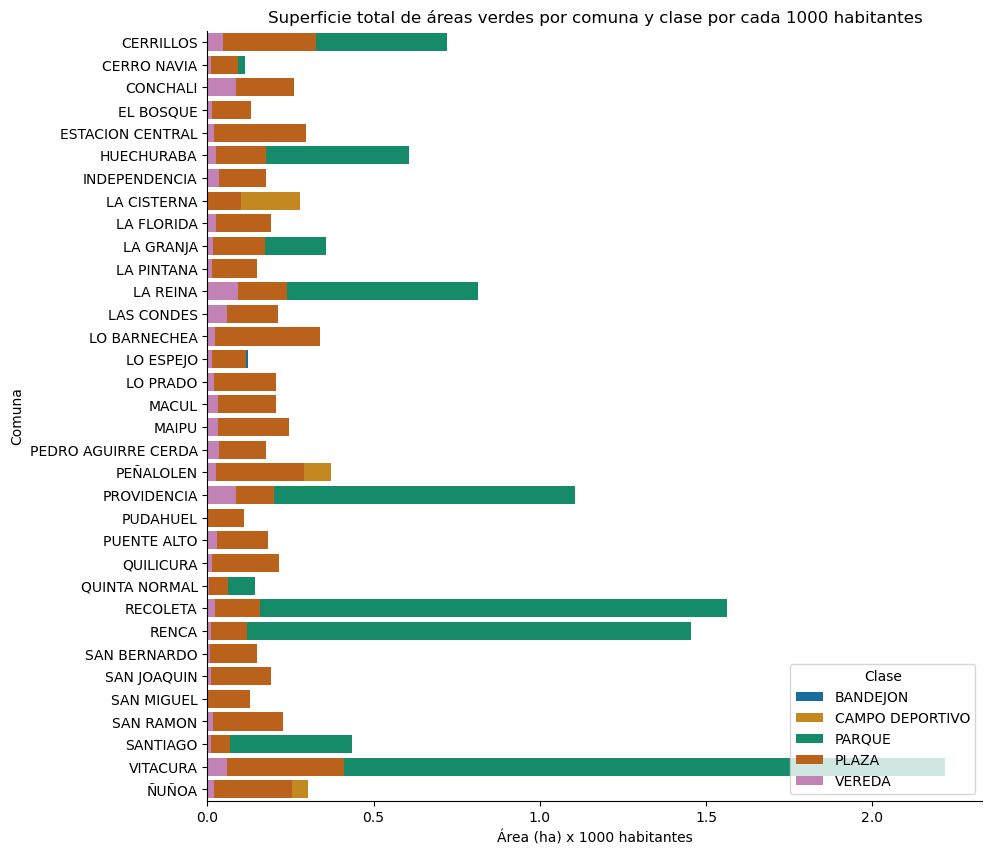

In [11]:
# obtenemos la población de cada comuna
persona_hogar = personas.merge(hogares)
poblacion_por_comuna = persona_hogar.groupby('Comuna')['FactorPersona'].sum().rename('population')

# obtenemos areas verdes por comuna y clase
area_comuna_clase = areas_verdes.groupby(["Comuna", "clase"]).agg({"area_m2": "sum", "Comuna": "count", "area_ha": "sum"}).rename(columns={"Comuna": "n_areas"}).reset_index()

# obtenemos hectareas de areas verdes por 1000 habitantes
area_comuna_clase_por_1000_habitantes = area_comuna_clase.merge(poblacion_por_comuna, on='Comuna')
area_comuna_clase_por_1000_habitantes['area_ha_por_1000_habitantes'] = area_comuna_clase_por_1000_habitantes['area_ha'] / area_comuna_clase_por_1000_habitantes['population'] * 1000

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    data=area_comuna_clase_por_1000_habitantes,
    x="area_ha_por_1000_habitantes",
    y="Comuna",
    hue="clase",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Área (ha) x 1000 habitantes")
ax.set_ylabel("Comuna")
ax.set_title("Superficie total de áreas verdes por comuna y clase por cada 1000 habitantes")
ax.legend(title="Clase", loc="lower right")
sns.despine()

area_comuna_clase_por_1000_habitantes

### ¿Cuanta gente vive cerca de cada area verde?


### ¿Cuanta gente trabaja cerca de cada area verde?

### ¿Flujo de personas cerca de cada areas verde?


### ¿Hay correlacion entre tasa de areas verdes por habitante e ingreso comunal promedio?

,Comuna,area_ha_por_1000_habitantes,ingreso promedio
32,VITACURA,4.762480,1.666897e+06
11,LA REINA,1.952430,1.521881e+06
25,RECOLETA,1.749128,6.350697e+05
0,CERRILLOS,1.716742,5.287505e+05
26,RENCA,1.604333,5.203086e+05
20,PROVIDENCIA,1.474332,1.370451e+06
5,HUECHURABA,0.928426,7.918456e+05
19,PEÑALOLEN,0.783795,7.617944e+05
12,LAS CONDES,0.717250,1.460452e+06
33,ÑUÑOA,0.669322,1.145987e+06


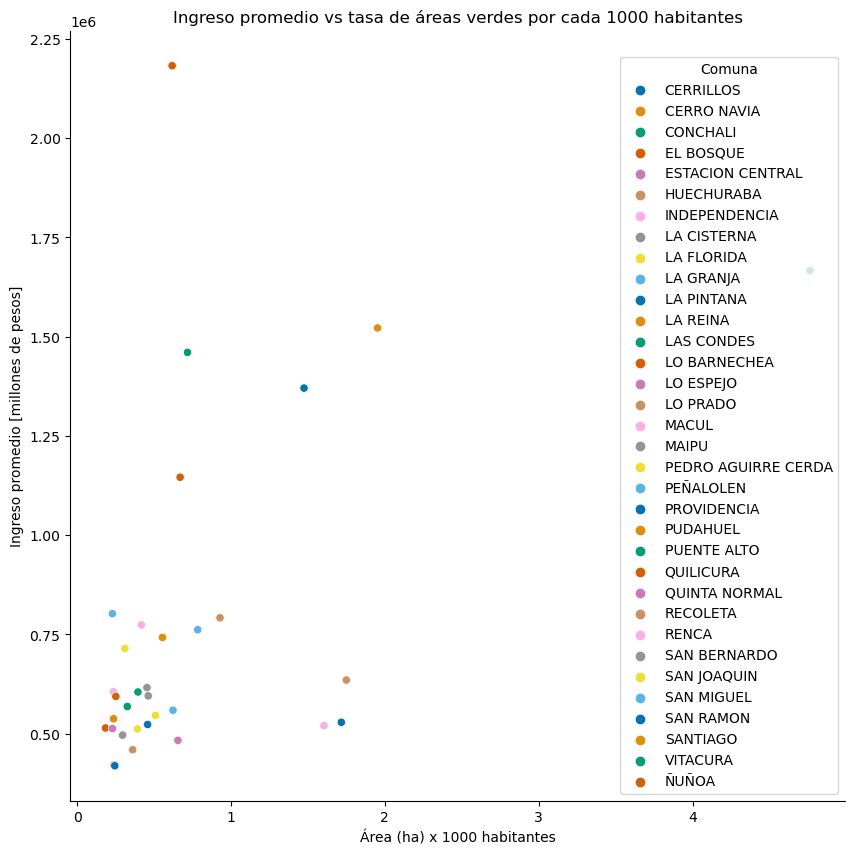

In [53]:
from aves.features.utils import weighted_mean

# obtenemos ingreso promedio por comuna
ingreso_comunal_promedio = hogares.groupby('Comuna').apply(lambda x: weighted_mean(x, 'IngresoHogar', 'FactorHogar')).rename('ingreso promedio')
ingreso_comunal_promedio

# obtenemos la población de cada comuna
persona_hogar = personas.merge(hogares)
poblacion_por_comuna = persona_hogar.groupby('Comuna')['FactorPersona'].sum().rename('population')

# obtenemos areas verdes por comuna
area_comuna = areas_verdes.groupby("Comuna").agg({"area_m2": "sum", "Comuna": "count", "area_ha": "sum"}).rename(columns={"Comuna": "n_areas"}).reset_index()

# obtenemos hectareas de areas verdes por 1000 habitantes
area_comuna_por_1000_habitantes = area_comuna.merge(poblacion_por_comuna, on='Comuna')
area_comuna_por_1000_habitantes['area_ha_por_1000_habitantes'] = area_comuna_por_1000_habitantes['area_ha'] / area_comuna_por_1000_habitantes['population'] * 1000

df = area_comuna_por_1000_habitantes.merge(ingreso_comunal_promedio, on='Comuna')[['Comuna', 'area_ha_por_1000_habitantes', 'ingreso promedio']]

#plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    data=df,
    x="area_ha_por_1000_habitantes",
    y="ingreso promedio",
    hue="Comuna",
    ax=ax,
    palette="colorblind",
)
ax.set_xlabel("Área (ha) x 1000 habitantes")
ax.set_ylabel("Ingreso promedio [millones de pesos]")
ax.set_title("Ingreso promedio vs tasa de áreas verdes por cada 1000 habitantes")
ax.legend(title="Comuna", loc="lower right")
sns.despine()

#df.sort_values('ingreso promedio', ascending=False)
df.sort_values('area_ha_por_1000_habitantes', ascending=False)

### ¿Cual es la distribucion de distancia o tiempo de viaje a areas verdes en distintos sectores de la ciudad?